# COGS 189 Analysis

In [1]:
import numpy as np   
import matplotlib.pyplot as plt    
import pandas as pd
import mne

# Read data with added stim channel
See find_peaks_stim_channel.ipynb for generating the stim channel from aux data.

In [2]:
#data = pd.read_csv("exp0_sub0_8ch_1stim.csv") # Amy
data = pd.read_csv("exp0_sub1_8ch_1stim.csv") # Andres
data.head()

,Unnamed: 0,EXG0,EXG1,EXG2,EXG3,EXG4,EXG5,EXG6,EXG7,Analog0,Analog1,Analog2,Timestamp,stim
0,0,9300.493813,5678.594789,4625.782922,19128.265277,18577.361831,13177.269778,9226.397780,14519.670846,321.0,249.0,511.0,1.677711e+09,0
1,1,9299.756205,5700.320685,4627.056971,19136.915402,18580.178151,13180.354319,9194.725358,14523.358884,321.0,249.0,511.0,1.677711e+09,0
2,2,9297.409272,5685.367368,4628.711001,19137.451844,18581.183980,13185.025833,9204.426015,14525.862280,321.0,249.0,511.0,1.677711e+09,0
3,3,9298.638618,5664.446135,4626.788751,19138.927059,18580.468724,13191.932522,9208.494032,14526.577535,321.0,249.0,511.0,1.677711e+09,0
4,4,9301.164365,5677.767775,4625.224128,19147.465425,18584.983776,13194.257104,9215.914812,14515.848698,321.0,249.0,511.0,1.677711e+09,0


<AxesSubplot: >

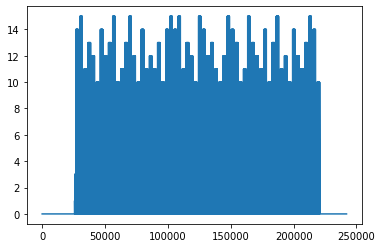

In [3]:
data['stim'].plot()

# Import Channel Map
(this was just written out as a txt file during data collection)

In [4]:
chan_map_path = r'../data/exp0/OpenBCISession_2023-03-01_13-30-42/chan_map.txt'
# for exp0, same channel map was used for both subjects

chan_map = pd.read_csv(chan_map_path,
                      delimiter='\t')
chan_map

,Cyton,004
0,REF,CPz
1,GND,AFz
2,1,Fz
3,2,Cz
4,3,Pz
5,4,Fp1
6,5,F7
7,6,T6
8,7,T4
9,8,T3


# Make an MNE Info Object

In [5]:
FS_EEG = 250.0

col_names = data.keys()
print('#Channels:', len(col_names))

# Container to populate with MNE channel types
ch_names = ['']*len(col_names)
ch_types = ['']*len(col_names)

ch_ndx = 0
for col in col_names:
    # print(ch_ndx, col)
    if 'EXG' in col:
        ch_names[ch_ndx] = chan_map.iloc[ch_ndx+1, 1]
        print(ch_ndx, ch_names[ch_ndx])
        ch_types[ch_ndx] = 'eeg'
    elif 'stim' in col:
        ch_names[ch_ndx] = col
        ch_types[ch_ndx] = 'stim'
    else: # Analog / Timestamp
        ch_names[ch_ndx] = col
        ch_types[ch_ndx] = 'misc'
    ch_ndx += 1

info = mne.create_info(
    ch_names=ch_names, 
    sfreq=FS_EEG, 
    ch_types=ch_types
)

# Apply 10-20 montage for these channels
info.set_montage('standard_1020', match_case=False)

#Channels: 14
1 Fz
2 Cz
3 Pz
4 Fp1
5 F7
6 T6
7 T4
8 T3


<Info | 8 non-empty values
 bads: []
 ch_names: Unnamed: 0, Fz, Cz, Pz, Fp1, F7, T6, T4, T3, Analog0, Analog1, ...
 chs: 5 misc, 8 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 250.0 Hz
>

# Import the data into MNE

In [6]:
# Need to transpose the data
raw = mne.io.RawArray(data.T, info)

raw

Creating RawArray with float64 data, n_channels=14, n_times=242140
    Range : 0 ... 242139 =      0.000 ...   968.556 secs
Ready.


<RawArray | 14 x 242140 (968.6 s), ~25.9 MB, data loaded>

# Try a PSD plot of raw data
Watch out for 60 Hz!

Using matplotlib as 2D backend.


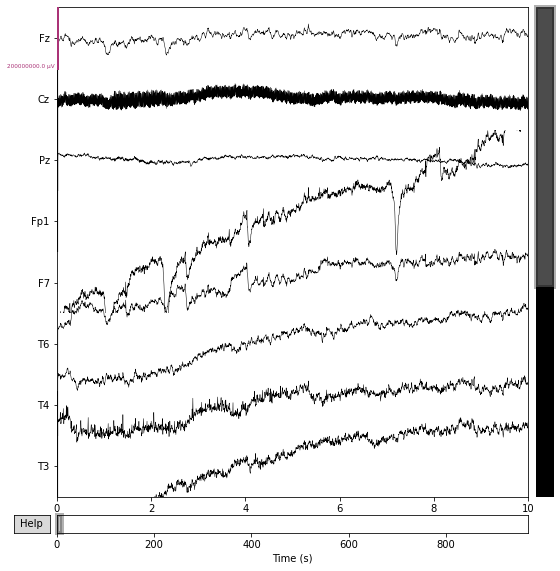

Effective window size : 1.024 (s)


/usr/local/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


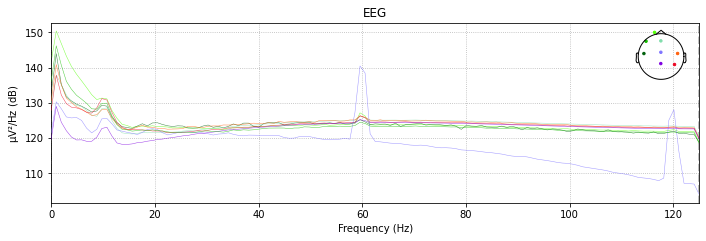

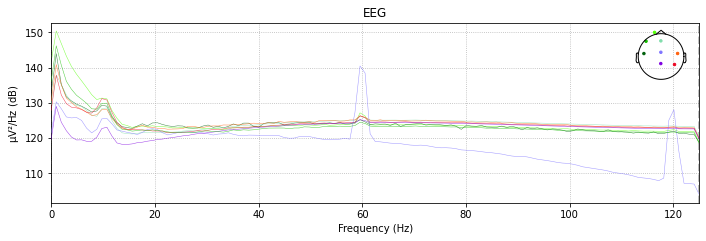

In [7]:
scalings = {'eeg': 100, 'bio': 1, 'time': 1}

raw.plot(n_channels=8, scalings=scalings, title='test',
         show=True, block=True)


raw.compute_psd().plot(average = False)

# Bandpass Filter
https://mne.tools/dev/auto_tutorials/preprocessing/30_filtering_resampling.html

In [8]:
raw_filtered = raw.copy().filter(
    l_freq = 0.1, 
    h_freq = 30
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


Effective window size : 1.024 (s)


/usr/local/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


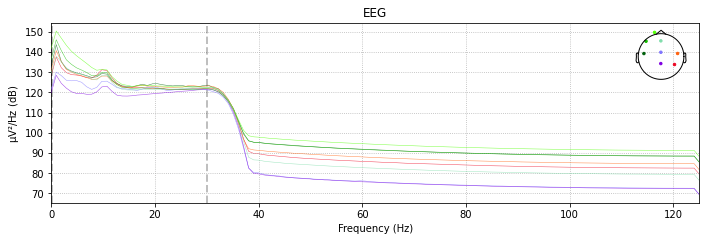

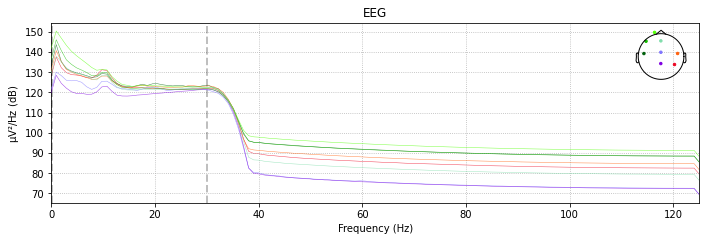

In [9]:
raw_filtered.compute_psd().plot(average = False)

# Epoch
https://mne.tools/stable/generated/mne.find_events.html

## Trigger Labels

Trigger | Description
:-- | :--
0 | nothing
1 | trial start (loud cue)
2 | loud cue
3 | soft cue
X | auto-assigned by stim wave used

X by stim file used:

```
 'audio/exp0/kick_iso.wav': 10,
 'audio/exp0/kick_mp1.wav': 11,
 'audio/exp0/kick_mp2.wav': 12,
 'audio/exp0/snare_iso.wav': 13,
 'audio/exp0/snare_mp1.wav': 14,
 'audio/exp0/snare_mp2.wav': 15
```

In [10]:
mne.find_events(raw)

1440 events found
Event IDs: [ 1  2  3 10 11 12 13 14 15]


array([[ 25797,      0,      1],
       [ 25922,      0,      3],
       [ 26048,      0,      3],
       ...,
       [220418,      0,     10],
       [220543,      0,     10],
       [220672,      0,     10]])